# Template Model Classification - Dataset IQRfiltered

In [1]:
#import semua library yg bakalan dipake di sini, biar rapih
#kalo kurang tambahin aja yaa wkwkwk


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, auc, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

# IMPORT & SPLIT DATASET

In [2]:
df_train_iqrfiltered = pd.read_csv('processed_dataset/Train/processed_Train_IQR_filtered.csv')
df_test_iqrfiltered = pd.read_csv('processed_dataset/Test/processed_Test_IQR_filtered.csv')

In [3]:
df_train_iqrfiltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         6400 non-null   float64
 1   Customer_rating             6400 non-null   float64
 2   Cost_of_the_Product         6400 non-null   float64
 3   Prior_purchases             6400 non-null   float64
 4   Discount_offered            6400 non-null   float64
 5   Weight_in_gms               6400 non-null   float64
 6   Gender_encoded              6400 non-null   int64  
 7   Product_importance_encoded  6400 non-null   int64  
 8   Warehouse_block_A           6400 non-null   int64  
 9   Warehouse_block_B           6400 non-null   int64  
 10  Warehouse_block_C           6400 non-null   int64  
 11  Warehouse_block_D           6400 non-null   int64  
 12  Warehouse_block_F           6400 non-null   int64  
 13  Mode_of_Shipment_Flight     6400 

In [4]:
df_test_iqrfiltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6341 entries, 0 to 6340
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         6341 non-null   float64
 1   Customer_rating             6341 non-null   float64
 2   Cost_of_the_Product         6341 non-null   float64
 3   Prior_purchases             6341 non-null   float64
 4   Discount_offered            6341 non-null   float64
 5   Weight_in_gms               6341 non-null   float64
 6   Gender_encoded              6341 non-null   int64  
 7   Product_importance_encoded  6341 non-null   int64  
 8   Warehouse_block_A           6341 non-null   int64  
 9   Warehouse_block_B           6341 non-null   int64  
 10  Warehouse_block_C           6341 non-null   int64  
 11  Warehouse_block_D           6341 non-null   int64  
 12  Warehouse_block_F           6341 non-null   int64  
 13  Mode_of_Shipment_Flight     6341 

In [5]:
#split X dan Y 
#moga2 split train sama testnya bener ya KWKWKWKWK

X_train = df_train_iqrfiltered.drop('arrived_late', axis = 1)
y_train = df_train_iqrfiltered['arrived_late']
X_test = df_test_iqrfiltered.drop('arrived_late', axis = 1)
y_test = df_test_iqrfiltered['arrived_late']

# FUNCTIONS

In [6]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
#     print("AUC (test-label): %.2f" % roc_auc_score(y_test, y_pred))
#     print("AUC (train-label): %.2f" % roc_auc_score(y_train, y_pred_train))
    print('\n------------------------\n')
    print(classification_report(y_test, y_pred))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

#feature importance untuk SVM
def feature_plot(classifier, feature_names, top_features=8):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 0 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
    plt.show()

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [7]:
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(C, train_scores, label='Train')
    plt.plot(C, test_scores, label='Test')
    plt.legend()
    plt.show()

# AdaBoost (Riyan)

In [8]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
eval_classification(ada)

Accuracy (Test Set): 0.61
Precision (Test Set): 0.67
Recall (Test Set): 0.43
F1-Score (Test Set): 0.52
AUC (test-proba): 0.64
AUC (train-proba): 0.64

------------------------

              precision    recall  f1-score   support

           0       0.58      0.79      0.67      3200
           1       0.67      0.43      0.52      3141

    accuracy                           0.61      6341
   macro avg       0.63      0.61      0.60      6341
weighted avg       0.63      0.61      0.60      6341



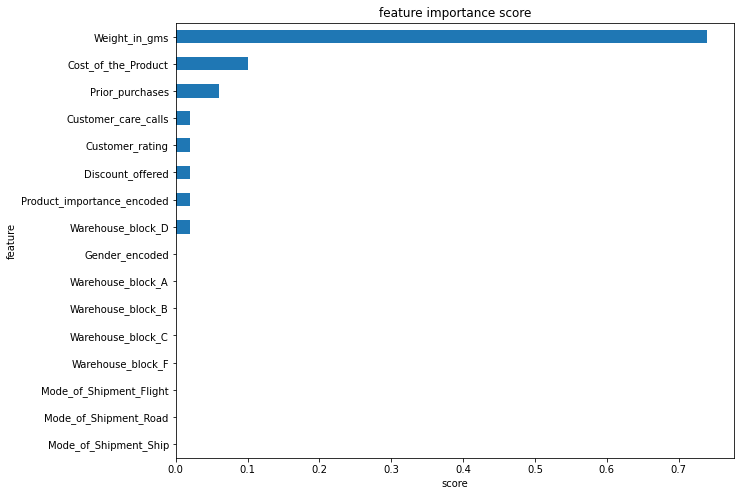

In [9]:
show_feature_importance(ada)

# Logistic Regression (Arsya)

In [10]:
logres=LogisticRegression(random_state=42)
logres.fit(X_train, y_train)
eval_classification(logres)

Accuracy (Test Set): 0.56
Precision (Test Set): 0.56
Recall (Test Set): 0.53
F1-Score (Test Set): 0.55
AUC (test-proba): 0.60
AUC (train-proba): 0.60

------------------------

              precision    recall  f1-score   support

           0       0.56      0.59      0.58      3200
           1       0.56      0.53      0.55      3141

    accuracy                           0.56      6341
   macro avg       0.56      0.56      0.56      6341
weighted avg       0.56      0.56      0.56      6341



In [11]:
show_feature_importance(logres)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# Decision Tree (Edo)

In [12]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
eval_classification(dt)

Accuracy (Test Set): 1.00
Precision (Test Set): 1.00
Recall (Test Set): 1.00
F1-Score (Test Set): 1.00
AUC (test-proba): 1.00
AUC (train-proba): 1.00

------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3200
           1       1.00      1.00      1.00      3141

    accuracy                           1.00      6341
   macro avg       1.00      1.00      1.00      6341
weighted avg       1.00      1.00      1.00      6341



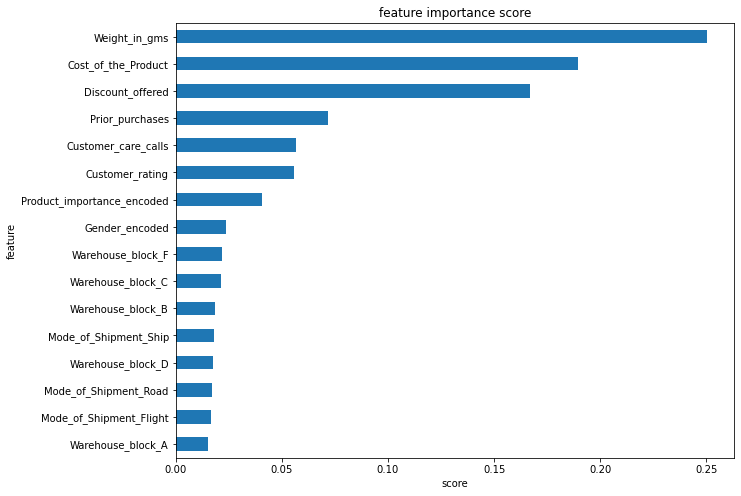

In [13]:
show_feature_importance(dt)

# Random Forest(Afif)

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
eval_classification(rf)

Accuracy (Test Set): 1.00
Precision (Test Set): 1.00
Recall (Test Set): 1.00
F1-Score (Test Set): 1.00
AUC (test-proba): 1.00
AUC (train-proba): 1.00

------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3200
           1       1.00      1.00      1.00      3141

    accuracy                           1.00      6341
   macro avg       1.00      1.00      1.00      6341
weighted avg       1.00      1.00      1.00      6341



Semua hasil evaluasi memiliki nilai 1.0 hal yang sangat mustahil di dunia nyata, apakah ada kesalahan? Diperlukan tunning untuk mengurangi nilainya.

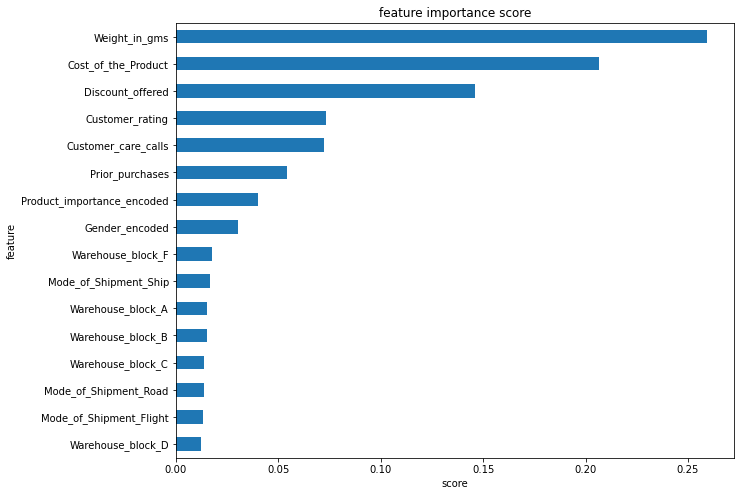

In [15]:
show_feature_importance(rf)

Feature yang paling penting dari model ini adalah weight_in_gms

# Support Vector Classifier (Ahdan)

# K-Nearest Neighbor (Agas)

In [25]:
knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

KNeighborsClassifier()

In [26]:
y_pred = knn.predict(X_test)
classification_report(knn)

AttributeError: 'NoneType' object has no attribute 'split'

# XGBoost (Almas)

In [16]:
xgb = XGBClassifier()

In [17]:
xgb.fit(X_train,y_train)
eval_classification(xgb)

Accuracy (Test Set): 0.90
Precision (Test Set): 0.94
Recall (Test Set): 0.86
F1-Score (Test Set): 0.90
AUC (test-proba): 0.97
AUC (train-proba): 0.97

------------------------

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3200
           1       0.94      0.86      0.90      3141

    accuracy                           0.90      6341
   macro avg       0.91      0.90      0.90      6341
weighted avg       0.91      0.90      0.90      6341



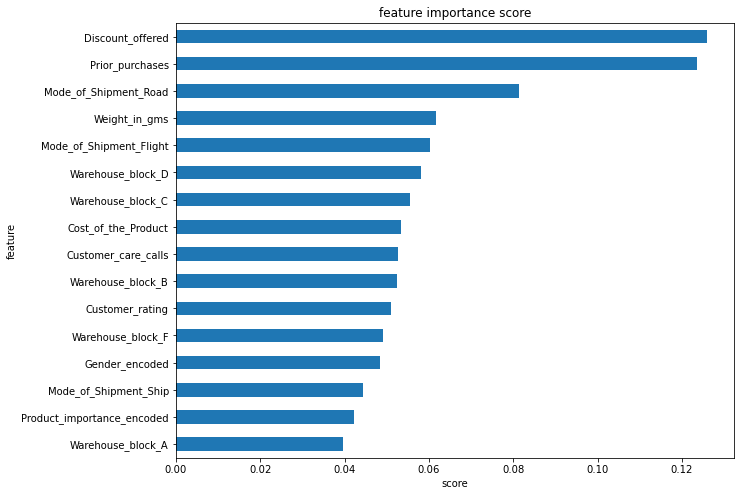

In [18]:
show_feature_importance(xgb)